In [1]:
import numpy as np 
import pandas as pd 
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Headers required for stats.nba.com
HEADERS = {
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://www.nba.com/',
    'Origin': 'https://www.nba.com',
    'Connection': 'keep-alive',
}

In [2]:
class Team:
    def __init__(self, name, wins, games_played=41):
        self.name = name
        self.wins = wins
        self.games_played = games_played
        self.n = wins / games_played
        self.a1, self.b1, self.c1, self.d1, self.a2, self.b2, self.c2, self.d2 = generate_ordered_constants(self.n)

    def payoff_matrix(self):
        """
        Returns two 2×2 arrays: (playoff_matrix, draft_matrix) according to GT equation
        """
        playoff_matrix = np.array([[self.a1, self.b1],
                                   [self.c1, self.d1]])
        draft_matrix   = np.array([[self.a2, self.b2],
                                   [self.c2, self.d2]])
        return playoff_matrix, draft_matrix

    def describe_matrix(self):
        """
        Creates  the expected payoff matrix 
          M_exp = n·M_playoff + (1−n)·M_draft,
        and then sums all entries to one float.
        """
        M_playoff, M_draft = self.payoff_matrix()
        M_exp = self.n * M_playoff + (1 - self.n) * M_draft
        scalar_payoff = M_exp.sum()  # sum over all four entries
        return scalar_payoff

    def __repr__(self):
        return f"Team(name={self.name!r}, wins={self.wins}, games_played={self.games_played})"

    def __str__(self):
        scalar = self.describe_matrix()
        return (
            f"Team: {self.name}\n"
            f"  Win‐Rate (n)        = {self.n:.3f}\n"
            f"  Scalar Payoff = {scalar:.3f}"
        )


In [3]:
def tank_GT(team: Team):
    n = team.n
    playoff_matrix, draft_matrix = team.payoff_matrix()

    # Expected payoff matrix as weighted average where each scalar is applied to its matrix and the results are summed 
    expected_matrix = n * playoff_matrix + (1 - n) * draft_matrix
    return expected_matrix


In [4]:
def generate_ordered_constants(n):
    """
    Generate (a1,b1,c1,d1,a2,b2,c2,d2) based on current win-rate n ∈ [0,1].
    Here:
      - a2,b2,c2,d2 are 'draft-centric' payoffs ∝ (1 − n).
      - a1,b1,c1,d1 are 'playoff-centric' payoffs ∝ n, offset by small random noise.
    """
    # 1) Draft matrix constants scale with (1 − n):
    #    bigger (1-n) ⇒ bigger draft payoffs (stronger incentive to tank).
    a2 = (1 - n) * 10 + np.random.uniform(0, 1)   # best draft reward if tanking
    b2 = (1 - n) * 8  + np.random.uniform(0, 1)   # middle reward
    c2 = (1 - n) * 5  + np.random.uniform(0, 1)
    d2 = (1 - n) * 2  + np.random.uniform(0, 1)

    # 2) Playoff matrix constants scale with n:
    #    bigger n ⇒ bigger playoff rewards (stronger incentive to compete).
    #    We ensure “playoff” entries are generally larger than “draft” entries 
    #    for positive n. You can adjust these offsets to match your paper’s intuition.
    a1 = a2 + np.random.uniform(1, 2)       # prefer winning playoffs even if other tanks
    b1 = b2 - np.random.uniform(1, 2)       # low‐seed playoff vs. decent draft pick
    c1 = c2 + np.random.uniform(1, 2)       # winning when others tank ⇒ strong
    d1 = c1 + np.random.uniform(1, 2)       # both teams “good” ⇒ best outcome
    
    assert a1 > a2 and b1 < b2 and c1 > c2 and d1 > d2 and c1 < d1
    
    return a1, b1, c1, d1, a2, b2, c2, d2


In [5]:
for wins, gp in [(5, 20), (10, 20), (15, 20), (20, 20)]:
    t = Team("Testers", wins=wins, games_played=gp)
    print(f" Wins={wins}/{gp} (n={t.n:.3f})  →  Scalar Payoff = {t.describe_matrix():.3f}")


 Wins=5/20 (n=0.250)  →  Scalar Payoff = 22.151
 Wins=10/20 (n=0.500)  →  Scalar Payoff = 17.101
 Wins=15/20 (n=0.750)  →  Scalar Payoff = 11.424
 Wins=20/20 (n=1.000)  →  Scalar Payoff = 7.248


In [10]:
# ─── Cell C (updated) ──────────────────────────────────────────────────────────
def get_team_game_log(team_id, season):
    """
    Fetch a team's regular‐season game log from stats.nba.com for "season" 
    (e.g. '2023-24'). Returns a DataFrame sorted by date with columns:
      [GAME_DATE, WL, CUM_WINS, GAMES_PLAYED, …]
    """
    url = 'https://stats.nba.com/stats/teamgamelog'
    params = {
        'TeamID': team_id,
        'Season': season,
        'SeasonType': 'Regular Season'
    }
    resp = requests.get(url, headers=HEADERS, params=params)
    resp.raise_for_status()
    
    data = resp.json()['resultSets'][0]
    columns = data['headers']
    rows = data['rowSet']
    
    df = pd.DataFrame(rows, columns=columns)
    
    # Explicitly infer the ISO‐8601 format so pandas doesn't warn
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], infer_datetime_format=True)
    df = df.sort_values('GAME_DATE').reset_index(drop=True)
    
    # Compute cumulative wins
    wins = 0
    cum_wins = []
    for idx, row in df.iterrows():
        if row['WL'] == 'W':
            wins += 1
        cum_wins.append(wins)
    
    df['CUM_WINS'] = cum_wins
    df['GAMES_PLAYED'] = df.index + 1
    return df


In [11]:
# ─── Cell D (fixed) ────────────────────────────────────────────────────────────────
# Fetch the list of all teams (team IDs & names) from stats.nba.com
seasons = ['2023-24', '2022-23', '2021-22', '2020-21', '2019-20']
ref_season = seasons[0]  # e.g. '2023-24'

standings_url = 'https://stats.nba.com/stats/leaguestandingsv3'
params = {
    'LeagueID': '00',
    'Season': ref_season,
    'SeasonType': 'Regular Season'
}

resp = requests.get(standings_url, headers=HEADERS, params=params)
resp.raise_for_status()

data = resp.json()['resultSets'][0]
columns = data['headers']
rows = data['rowSet']

df_standings = pd.DataFrame(rows, columns=columns)

# The correct column names are 'TeamID' and 'TeamName'
teams_info = [
    (int(row['TeamID']), row['TeamName'])
    for _, row in df_standings.iterrows()
]


In [12]:
# ─── Cell E: Build `team_logs` for each (season, team_id) ───────────────────────────────
team_logs = {}

for season in seasons:
    for team_id, team_name in teams_info:
        try:
            df_log = get_team_game_log(team_id, season)
            team_logs[(season, team_id)] = (team_name, df_log)
        except Exception as e:
            print(f"Error fetching {team_name} ({team_id}) for {season}: {e}")


/var/folders/p7/p_zmlk9d3tv6xxnm607_6lcr0000gn/T/ipykernel_64588/1234893211.py:24: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], infer_datetime_format=True)
/var/folders/p7/p_zmlk9d3tv6xxnm607_6lcr0000gn/T/ipykernel_64588/1234893211.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], infer_datetime_format=True)
/var/folders/p7/p_zmlk9d3tv6xxnm607_6lcr0000gn/T/ipykernel_64588/1234893211.py:24: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the defau

KeyboardInterrupt: 

In [13]:
# ─── Cell F: Compute inner‐product payoffs each game, every team vs. every other ───────────────────────────────
payoff_results = {}

for season in seasons:
    payoff_results[season] = {}
    season_team_ids = [tid for (s, tid) in team_logs.keys() if s == season]

    for team_id in season_team_ids:
        team_name, df_team = team_logs[(season, team_id)]
        inner_products = []

        for idx, row in df_team.iterrows():
            wins = row['CUM_WINS']
            gp = row['GAMES_PLAYED']
            team_obj = Team(team_name, wins=wins, games_played=gp)
            pm, dm = team_obj.payoff_matrix()
            M_team = team_obj.n * pm + (1 - team_obj.n) * dm

            ip_dict = {}
            for opp_id in season_team_ids:
                if opp_id == team_id:
                    continue
                opp_name, df_opp = team_logs[(season, opp_id)]
                if len(df_opp) > idx:
                    opp_wins = df_opp.loc[idx, 'CUM_WINS']
                    opp_gp = df_opp.loc[idx, 'GAMES_PLAYED']
                    opp_obj = Team(opp_name, wins=opp_wins, games_played=opp_gp)
                    pm_opp, dm_opp = opp_obj.payoff_matrix()
                    M_opp = opp_obj.n * pm_opp + (1 - opp_obj.n) * dm_opp

                    ip = np.sum(M_team * M_opp)
                    ip_dict[opp_id] = ip

            inner_products.append(ip_dict)

        payoff_results[season][team_id] = inner_products


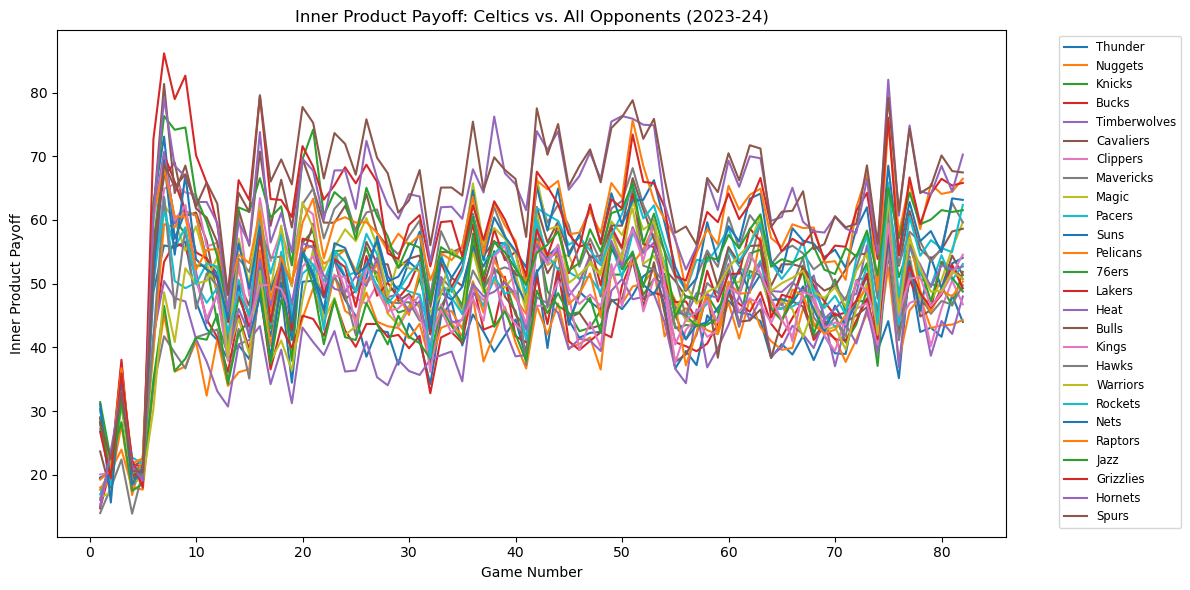

In [14]:
# ─── Cell G: Example plot for one team in one season ───────────────────────────────
season = '2023-24'
team_id = teams_info[0][0]   # e.g. first team in teams_info
team_name = next(name for tid, name in teams_info if tid == team_id)

inner_list = payoff_results[season][team_id]
df_ip = pd.DataFrame(inner_list).fillna(0)

plt.figure(figsize=(12, 6))
for opp_id in df_ip.columns:
    opp_name = next(name for tid, name in teams_info if tid == opp_id)
    plt.plot(df_ip.index + 1, df_ip[opp_id], label=opp_name)

plt.title(f'Inner Product Payoff: {team_name} vs. All Opponents ({season})')
plt.xlabel('Game Number')
plt.ylabel('Inner Product Payoff')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()
